<a href="https://colab.research.google.com/github/ethan-yoo/2022_AIFFEL/blob/main/E12_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **E12. Let's test OCR**

테서랙트와 케라스OCR를 사용해보고 어떤 서비스에서 어떤 폰트를 잘 잡는지 확인해보겠습니다.

(사실 네이버가 갑이에요. 찡긋)

---

In [ ]:
# !pip install tesseract
# !pip install keras_ocr
# !pip install pytesseract
# !pip install Pillow==9.0.0

# !sudo apt install tesseract-ocr
# !sudo apt install libtesseract-dev

## **00. 필요한 모듈 가져오기**

In [2]:
import tensorflow as tf
import keras_ocr
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import os
from PIL import Image

print(keras_ocr.__version__)
print(pytesseract.__version__)

0.9.1
0.3.9


In [3]:
# from google.colab import drive
# drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


## **01. Keras ocr**

In [4]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드함
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [5]:
# 테스트에 사용할 이미지 url 
image_urls = [
  '/content/mydrive/MyDrive/AIFFEL/E12/andreas-fickl-k-7JT9obpJw-unsplash.jpg',
  '/content/mydrive/MyDrive/AIFFEL/E12/caleb-gregory-kGa56RzfbIM-unsplash.jpg',
  '/content/mydrive/MyDrive/AIFFEL/E12/denise-jans-laoBHO09sU0-unsplash.jpg',
  '/content/mydrive/MyDrive/AIFFEL/E12/drew-beamer-Vc1pJfvoQvY-unsplash.jpg',
  '/content/mydrive/MyDrive/AIFFEL/E12/edward-howell-gM7hANhGSBU-unsplash.jpg'
]

images = [keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

사용할 이미지들은 깔끔한 폰트가 아닙니다.

벽에 쓰인 글씨거나, 폰트에 그림이 그려져 있거나, 일부가 아웃포커싱된 폰트들입니다.

현실에서는 그림처럼 깔끔하게 인식할 수 있게 데이터를 잘 뽑아주지 않기 때문에 성능 평가를 위해 일부러 노이즈가 낀 이미지들을 처리해보겠습니다.

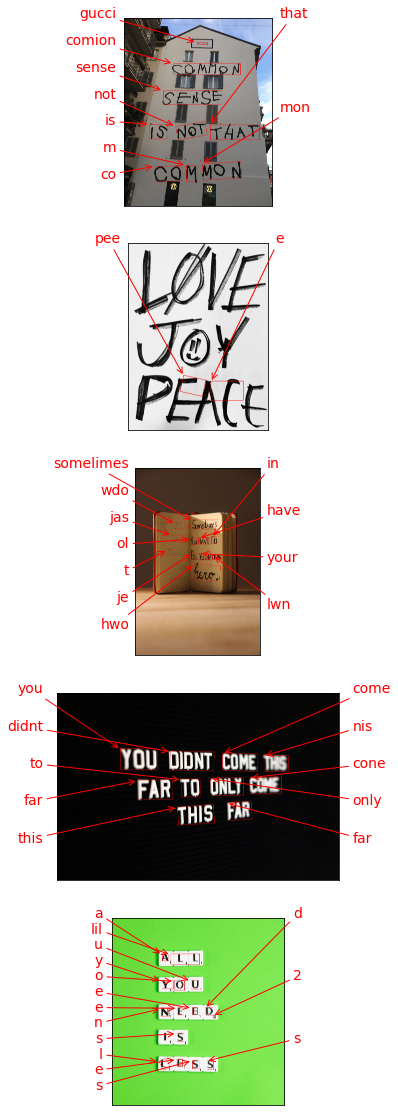

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

케라스OCR은 띄어쓰기 간격이 일정치 않거나, 폰트가 흐릿해지면 잘 인식하지 못합니다. 손글씨도 잘 인식하지 못하네요.

일정 크기 이하의 텍스트도 잘 인식하지 못합니다.

기울어진 텍스트도 잘 인식하지 못합니다. 아무래도 성능이 좀 시원찮은 면이 있네요.

---

## **02. 테서랙트**

In [9]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

# image_path='./images/sample.png', output_path='./output'
def crop_word_regions(image_path, output_path):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


듣기론 테서랙트가 성능이 조금 떨어진다고 합니다. 

그래서 앞서 사용한 예시 이미지보다 조금 더 나은 걸 준비했습니다.

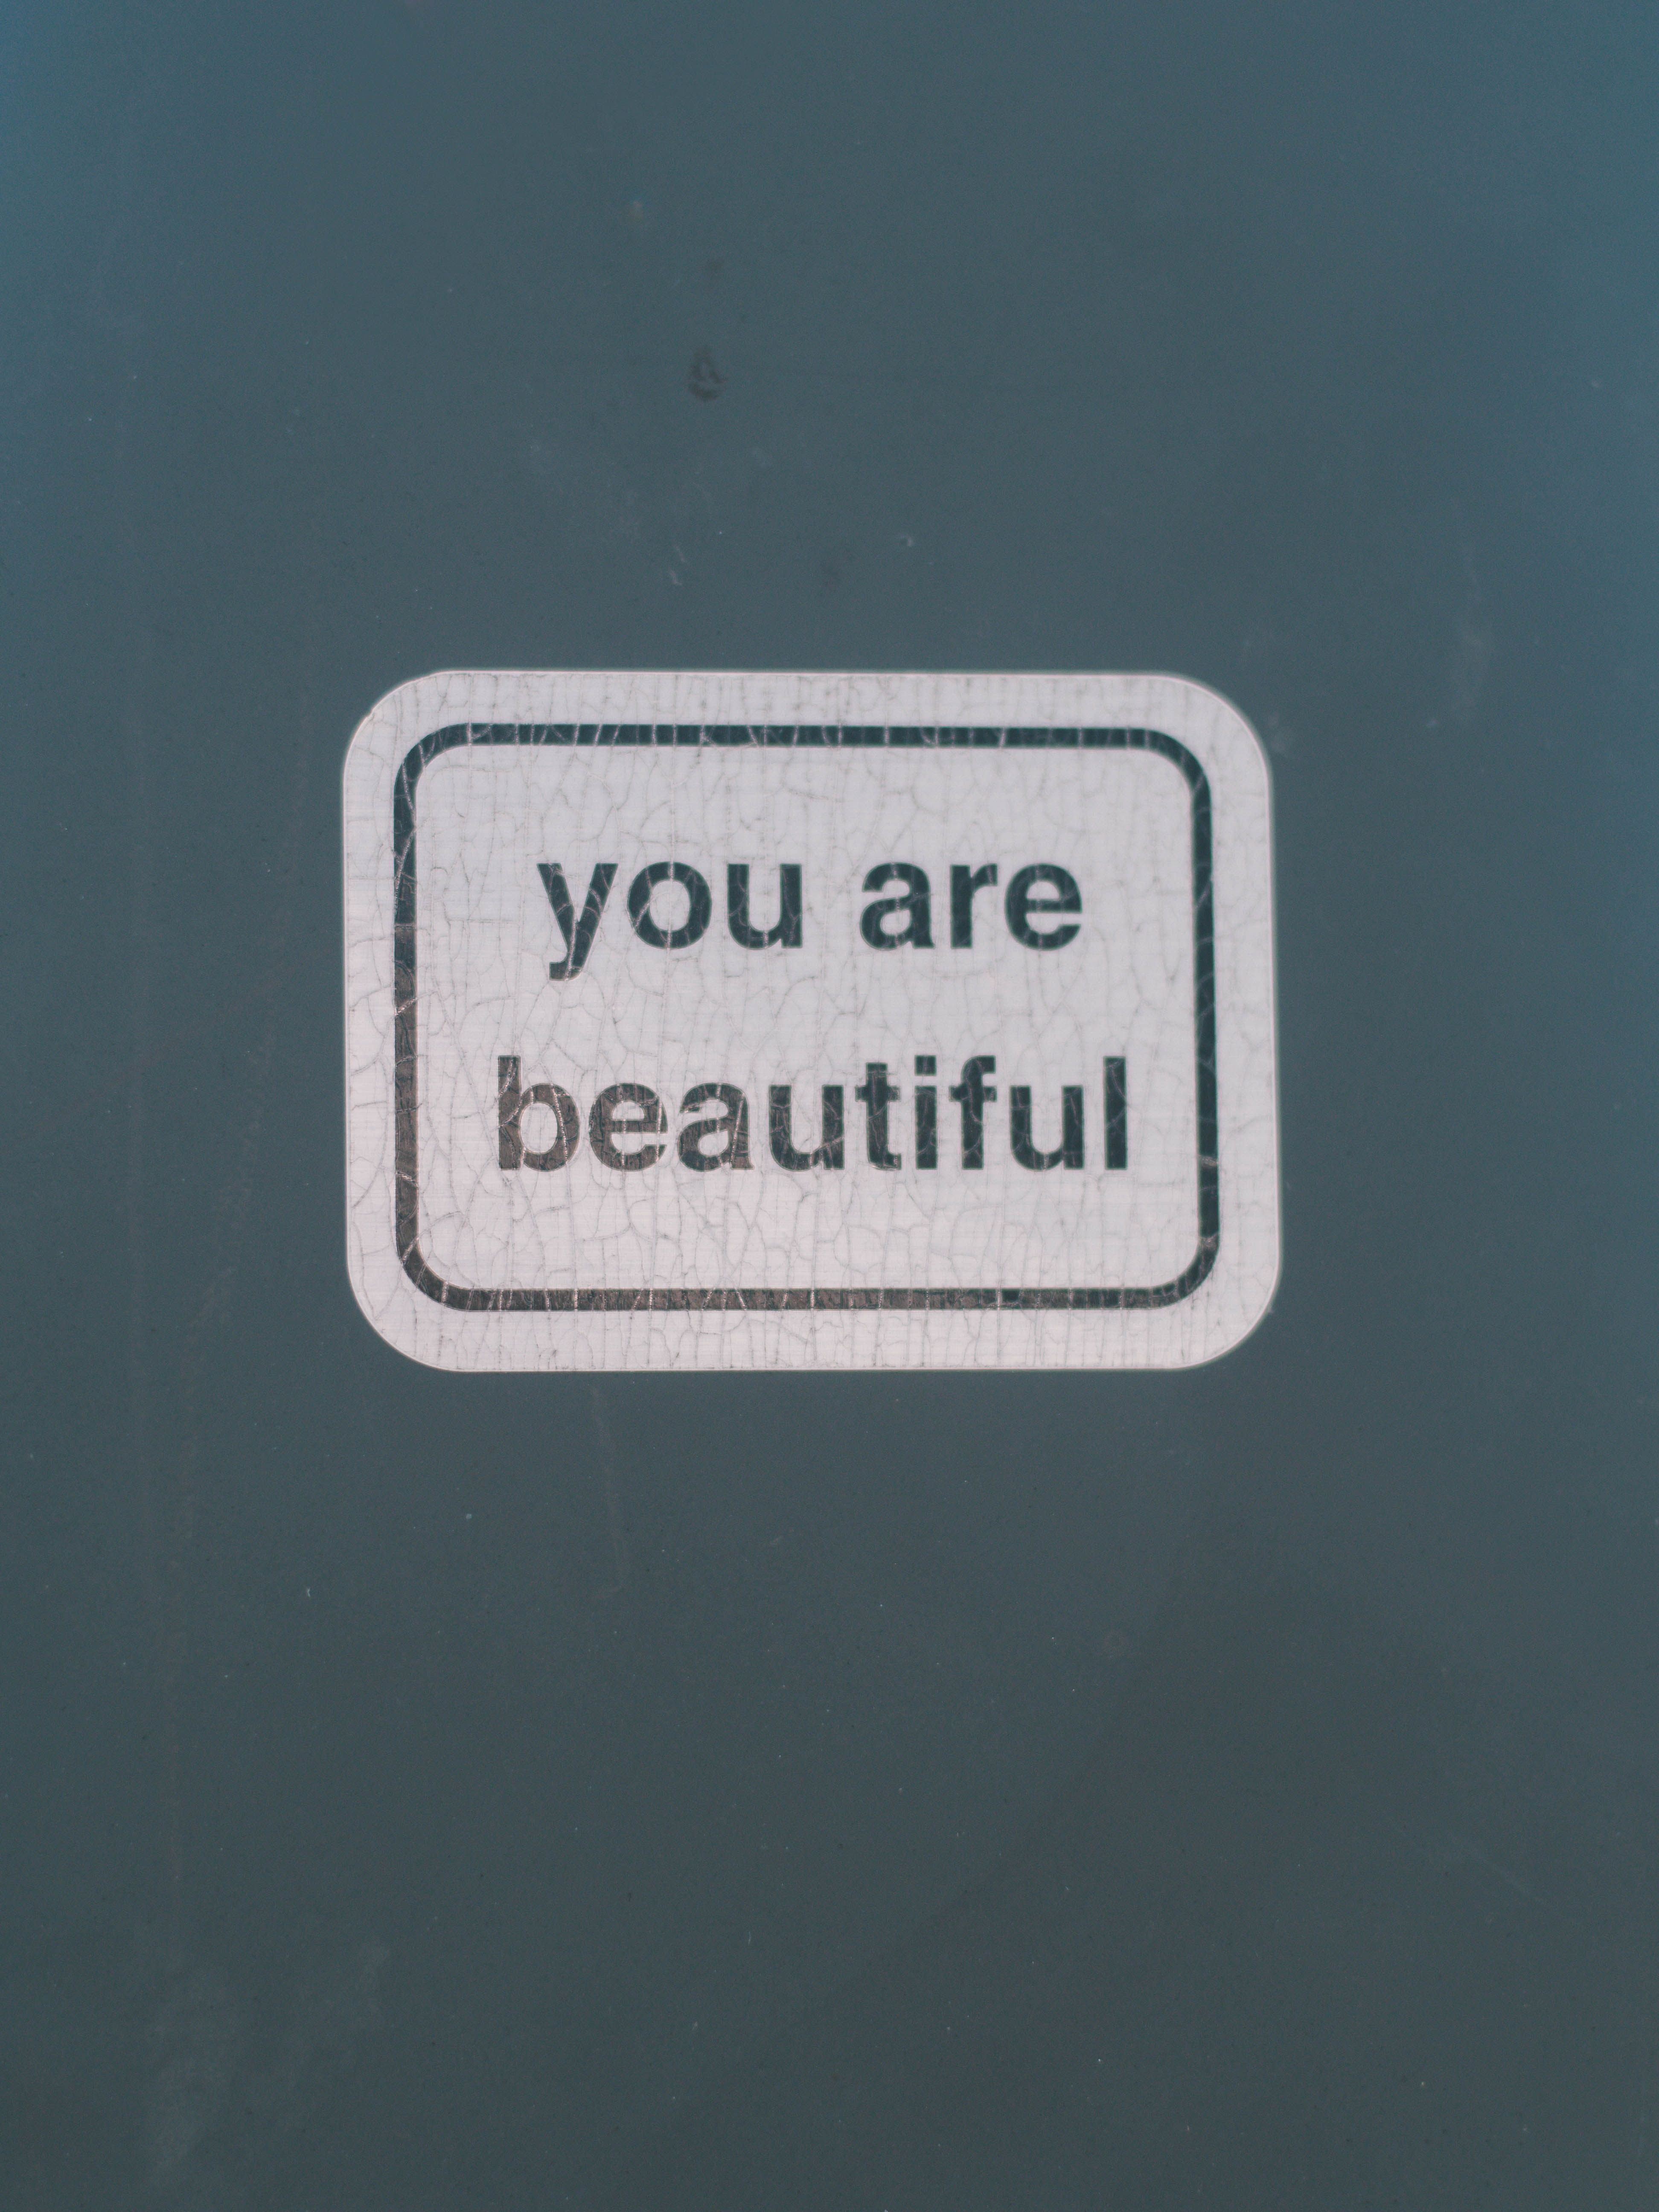

예시 이미지입니다. 그래도 비교적 노이즈가 적은 편이죠.

과연 얼마나 잘 출력할 수 있을까요?

In [11]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")


In [10]:
work_dir = '/content/mydrive/MyDrive/AIFFEL/E12'
img_file_path = '/content/mydrive/MyDrive/AIFFEL/E12/gio-bartlett-EJXN5hbNft0-unsplash.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/content/mydrive/MyDrive/AIFFEL/E12/0000.png
/content/mydrive/MyDrive/AIFFEL/E12/0001.png
/content/mydrive/MyDrive/AIFFEL/E12/0002.png


In [12]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력
recognize_images(cropped_image_path_list)

You

are


Done


테서랙트는 상당히 성능이 떨어지는 것 같군요.

혹시 모르니 케라스ocr로 테스트한 이미지들도 확인해보겠습니다.

In [13]:
img_file_path = '/content/mydrive/MyDrive/AIFFEL/E12/andreas-fickl-k-7JT9obpJw-unsplash.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/content/mydrive/MyDrive/AIFFEL/E12/0000.png
/content/mydrive/MyDrive/AIFFEL/E12/0001.png
/content/mydrive/MyDrive/AIFFEL/E12/0002.png
/content/mydrive/MyDrive/AIFFEL/E12/0003.png
CC@E£EE_L Sei istesiisiatiesstseesasisunnenstsssssssseessestinesmnsnememnemene see

‘



Done


In [14]:
img_file_path = '/content/mydrive/MyDrive/AIFFEL/E12/caleb-gregory-kGa56RzfbIM-unsplash.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/content/mydrive/MyDrive/AIFFEL/E12/0000.png

Done


In [15]:
img_file_path = '/content/mydrive/MyDrive/AIFFEL/E12/denise-jans-laoBHO09sU0-unsplash.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/content/mydrive/MyDrive/AIFFEL/E12/0000.png
;

Done


전반적으로 테서랙트의 성능이 압도적으로 낮습니다.

케라스가 썩 훌륭한 편은 아니지만, 그래도 문장을 상당수 읽어내는 데 비해

테서랙트는 노이즈가 끼면 거의 잡아내질 못하는군요.

## **03. 결론**

현실에서 사용할 OCR 데이터는 노이즈가 낀 경우가 훨씬 많을 겁니다.

그렇기 때문에 테서랙트보다는 keras ocr을 채택하는 게 낫다고 판단됩니다.


---

## **04. 회고**

- 사실 OCR은 현재 네이버가 압도적인 성능을 가지고 있습니다. 은행에서도 네이버의 신분증 인식 OCR 서비스를 사용하죠.

- CV 분야는 현재 이론의 발전이 상당히 진행되어 구체적인 프로덕트를 만들고 서비스하는 단계라고 들은 적이 있습니다. OCR도 그 중 한 예겠죠. 그래서 사실 약간 회의감이 드는 면도 있습니다. 업계 탑과의 기술력의 차이가 워낙 압도적이다 보니 몇 년이 지나면 사실상 일부 기업들의 독과점 시장이 되지 않을까요?